# NLP08- Seq2Seq : 한영번역기 만들기
# 목차

> LMS 따라해보기 

1. 데이터 전처리
2. 모델 설계
3. 훈련하기 
 * 1) Optimizer & Loss
 * 2) tran_step 구현
 * 3) 훈련 시작 




> 프로젝트: 한영 번역기 만들기

* Step 1. 데이터 다운로드
* Step 2. 데이터 정제
* Step 3. 데이터 토큰화
* Step 4. 모델 설계
* Step 5. 훈련하기



## 회고

# LMS 따라해보기 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 1.데이터 전처리

### 데이터 준비

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.9.2


* tf.keras.utils.get_file() 함수 :텐서플로우에서 제공하는 데이터 다운로드 함수
 * get_file()함수: URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제 

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

다운로드받은 데이터를 읽어온 후, 형태를 확인

In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print('\n')
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964


Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [5]:
type(raw)

list

In [6]:
len(raw)

118964

In [7]:
raw[0:200][::20]

['Go.\tVe.',
 'Wait.\tEsperen.',
 'Hug me.\tAbrázame.',
 'No way!\t¡Ni cagando!',
 'Call me.\tLlamame.',
 'Go away!\t¡Salga de aquí!',
 'Hang on.\tAgarra fuertemente.',
 'I moved.\tMe he trasladado.',
 'Perfect!\t¡Perfecto!',
 'Wake up!\t¡Despertate!']

In [8]:
raw[0:100][::20]

['Go.\tVe.',
 'Wait.\tEsperen.',
 'Hug me.\tAbrázame.',
 'No way!\t¡Ni cagando!',
 'Call me.\tLlamame.']

In [9]:
raw[0:100:20]

['Go.\tVe.',
 'Wait.\tEsperen.',
 'Hug me.\tAbrázame.',
 'No way!\t¡Ni cagando!',
 'Call me.\tLlamame.']

### 데이터 전처리 : 정제하기


소스 문장과 타겟 문장을 분리: 

해당 데이터는 \t 기호를 기준으로 영어와 스페인어가 병렬 쌍을 이루기에
 \t 기호를 매개변수로 split() 함수를 호출하여 분리

문장의 시작 문자 <start>, 종료 문자 <end> :

Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요


* 데이터 정제 함수 정의

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   #??
    sentence = re.sub(r'[" "]+', " ", sentence)         # 공백 여러개 공백하나로
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence) # 대소문자, 기본 특수기호 외는 공백하나로

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


In [11]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


### 데이터 전처리 : 토큰화

* tokenize() 함수 정의 

In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

* 토큰화: 텐서로 변환
* 훈련-검증 데이터 분리


In [13]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


In [14]:
enc_tensor, enc_tokenizer

(array([[ 34,   1,   0, ...,   0,   0,   0],
        [ 34,   1,   0, ...,   0,   0,   0],
        [ 34,   1,   0, ...,   0,   0,   0],
        ...,
        [ 14,  36, 722, ...,   0,   0,   0],
        [ 14,  36, 367, ...,   0,   0,   0],
        [ 14,  36,  70, ...,   0,   0,   0]], dtype=int32),
 <keras.preprocessing.text.Tokenizer at 0x7f1f4b7f42d0>)

In [15]:
tokenize(enc_corpus)

(array([[ 34,   1,   0, ...,   0,   0,   0],
        [ 34,   1,   0, ...,   0,   0,   0],
        [ 34,   1,   0, ...,   0,   0,   0],
        ...,
        [ 14,  36, 722, ...,   0,   0,   0],
        [ 14,  36, 367, ...,   0,   0,   0],
        [ 14,  36,  70, ...,   0,   0,   0]], dtype=int32),
 <keras.preprocessing.text.Tokenizer at 0x7f1f4b1ff450>)

## 2.모델 설계 : Seq2seq

 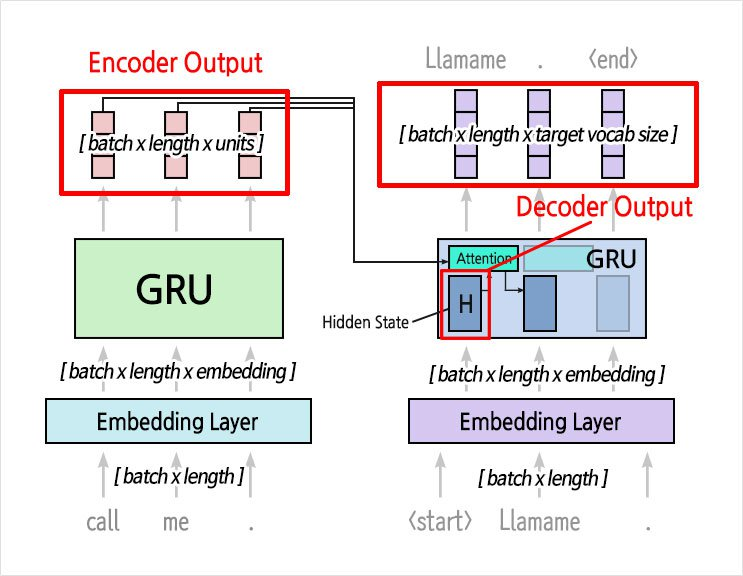

각각 1개의 GRU을 갖는 Encoder-Decoder 구조

### Bahdanau Attention

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


### Encoder

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

### Decoder

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)


# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 3.훈련하기 

### Optimizer & Loss

* Optimizer:  모델이 학습할 때에 정답을 찾아가는 방법 ( 주로 Adam 사용)
* Loss :  Encoder-Decoder 구로인해 직접 커스텀하여 사용 

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


 ### train_step 구현하기

* train_step() 정의 : 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환

💡 @tf.function 데코레이터: 

 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와준다. ( @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요)



💡 tf.GradientTape():

학습하며 발생한 모든 연산을 기록하는 테이프로 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용

In [21]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


### 훈련 시작하기

💡 tqdm:

훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리

In [22]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [00:15<00:00, 24.33it/s, Loss 0.1425]


### 실습하기

분리한 Validation Set을 사용하는 eval_step() 함수를 정의

⚠️  (주의! Evaluation 중에는 모델이 학습을 해서는 안 됩니다!)

In [23]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss



In [24]:
# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:01<00:00, 49.29it/s, Test Loss 0.7576]


번역 성능을 평가

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention



Attention Map으로 시각화하는 것는 보너스!

In [26]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


Input: can i have some coffee ?
Predicted translation: me dan un poco m s ? <end> 


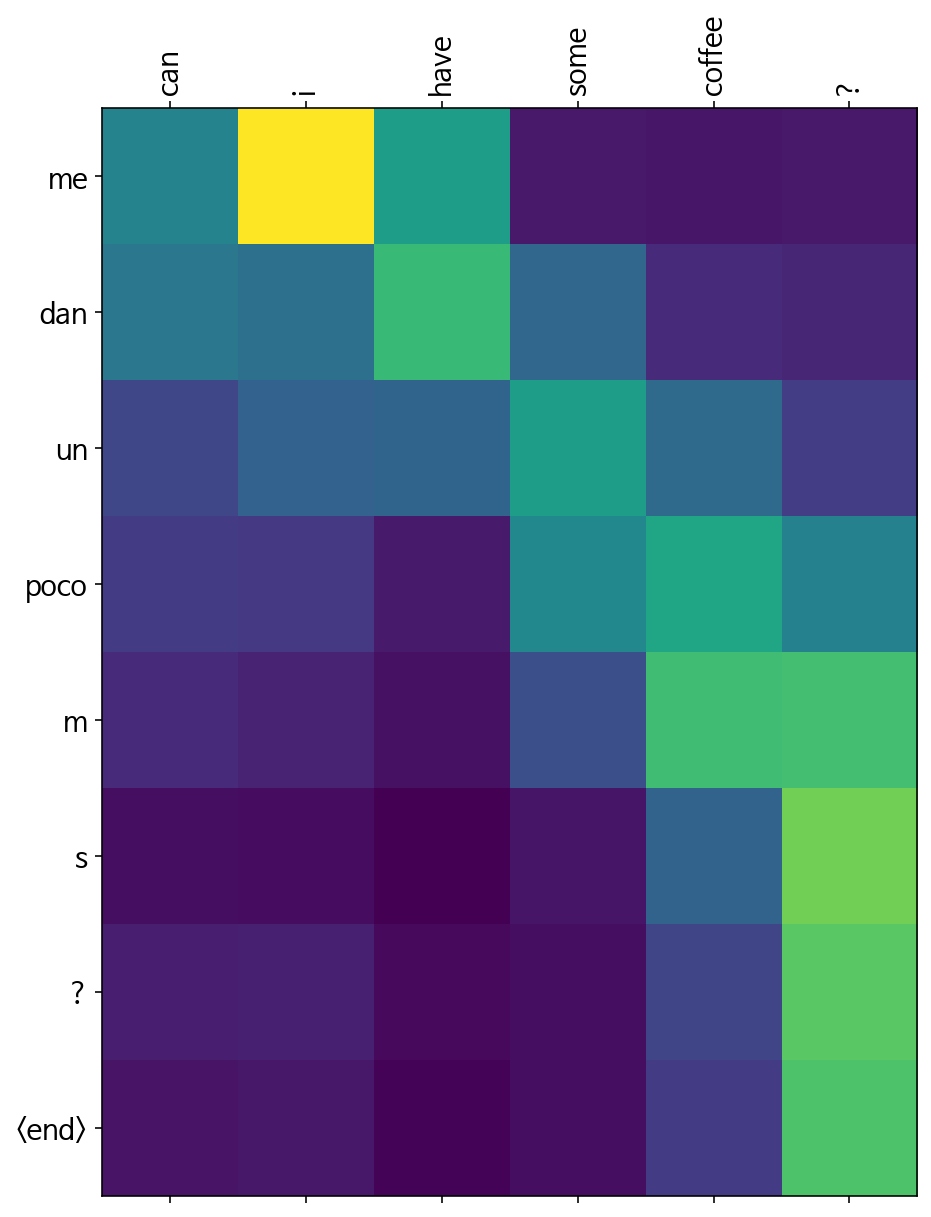

In [27]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

# 프로젝트: 한영 번역기 만들기


⚠️ 한글 폰트 표시

In [28]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontcon

In [29]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.5
2.9.2
3.2.2


In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.9.2



## Step 1. 데이터 다운로드


In [32]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

In [33]:
# path_to_zip = tf.keras.utils.get_file(
#     'korean-english-park.train.tar.gz',
#     origin='https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz',
#     extract=True)


In [34]:
# path_to_zip = tf.keras.utils.get_file(
#     'korean-english-park.train.tar.gz',
#     origin='https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz',
#     extract=True)


In [35]:
path_to_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
path_to_eng = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

In [36]:
with open(path_to_ko, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print('\n')
print("Example:")

for sen in raw_ko[0:100:20]: print(">>", sen)

Data Size: 94123


Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [37]:
with open(path_to_eng, "r") as f:
    raw_eng = f.read().splitlines()

print("Data Size:", len(raw_eng))
print('\n')
print("Example:")

for sen in raw_eng[0:100:20]: print(">>", sen)

Data Size: 94123


Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## Step 2. 데이터 정제


### 1)중복 제거 

In [38]:
#dataframe의 drop_duplicated 활용

pair_df = pd.DataFrame({'Korean':raw_ko, 'English':raw_eng})
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [39]:
print('전체 샘플수 :', (len(pair_df)))

전체 샘플수 : 94123


In [40]:
pair_df[pair_df.duplicated()]

,Korean,English
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
93792,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
93793,"이라크 새 의회, 첫 개정",Iraq’s new assembly is going to hold its first...
93933,"노 대통령 검찰, 민주적 통제 받아야 2005.12",Roh says prosecutors need civilian control.
94002,"카우치 멤버, 사전 모의 시인 2005.09",Members of The Couch planned it before the show.


In [41]:
# 중복 샘플 확인
print('Korean 열에서 중복을 배제한 유일한 샘플의 수 :', pair_df['Korean'].nunique())
print('English 열에서 중복을 배제한 유일한 샘플의 수 :', pair_df['English'].nunique())

Korean 열에서 중복을 배제한 유일한 샘플의 수 : 77591
English 열에서 중복을 배제한 유일한 샘플의 수 : 75598


In [42]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
pair_df.drop_duplicates(subset = ['English'], inplace=True)
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [43]:
print('전체 샘플수 :', (len(pair_df)))

전체 샘플수 : 75598


In [44]:
# .isnull().sum() : 데이터프레임에 Null 값이 있는지 확인
print(pair_df.isnull().sum())

Korean     0
English    0
dtype: int64


In [45]:
cleaned_df =pair_df

In [46]:
cleaned_corpus_kor = cleaned_df.Korean
cleaned_corpus_kor

0                     개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
1        모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2                               그러나 이것은 또한 책상도 필요로 하지 않는다.
3        79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...
4        정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
                               ...                        
94118    “우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...
94119     월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.
94120                         그러나 불충분한 증거 확보로 수사에 어려움이 있다.
94121                    김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.
94122    경찰은 김회장의 집무실에서 추가 증거를 찾은 이후 가능한 한 오늘 김회장과 아들을 ...
Name: Korean, Length: 75598, dtype: object

In [47]:
cleaned_corpus_kor[0]

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

In [48]:
cleaned_corpus_eng = cleaned_df.English
cleaned_corpus_eng

0        Much of personal computing is about "can you t...
1        so a mention a few weeks ago about a rechargea...
2        Like all optical mice, But it also doesn't nee...
3        uses gyroscopic sensors to control the cursor ...
4        Intelligence officials have revealed a spate o...
                               ...                        
94118    ””We are hoping to seize material evidence to ...
94119    ” On Monday, police secured statements from si...
94120    But the lack of material evidence is making it...
94121           Kim and his son both deny the allegations.
94122    Police are planning to seek arrest warrants fo...
Name: English, Length: 75598, dtype: object

In [49]:
cleaned_kor_list = cleaned_df['Korean'].values.tolist()
cleaned_kor_list[:5]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.']

In [50]:
cleaned_eng_list = cleaned_df['English'].values.tolist()
cleaned_eng_list[:5]

['Much of personal computing is about "can you top this?"',
 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "Like all optical mice, But it also doesn't need a desk.",
 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."]

In [51]:
print(len(cleaned_kor_list))
print(len(cleaned_eng_list))

75598
75598


### 2)정규표현식 

In [52]:
! pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from konlpy.tag import Mecab

⚠️ NameError: name 'Tagger' is not defined 

Mecab 설치시 오류 발생 : https://sosomemo.tistory.com/31

In [54]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 2s (129 kB/s)
Reading package lis

In [55]:

def preprocess_sentence_kor (sentence, s_token=False, e_token=False):

    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   #??
    sentence = re.sub(r'[" "]+', " ", sentence)         # 공백 여러개 공백하나로
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence) # 대소문자, 기본 특수기호 외는 공백하나로

    sentence = sentence.strip()     # 양쪽 공백 제거 

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    tokenizer = Mecab()
    
    sentence = tokenizer.morphs(sentence)

    return sentence


In [56]:
def preprocess_sentence_eng (sentence, s_token=False, e_token=False):

    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   #??
    sentence = re.sub(r'[" "]+', " ", sentence)         # 공백 여러개 공백하나로
    sentence = re.sub(r"[^a-zA-Z0-9?.!,]+", " ", sentence) # 대소문자, 기본 특수기호 외는 공백하나로

    sentence = sentence.strip()     # 양쪽 공백 제거 

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


In [57]:
# enc_corpus = []

# for ko in cleaned_ko_list[:10]:
#   enc_corpus.append(preprocess_sentence(ko))

# # enc_corpus 

In [58]:
# dec_corpus = []

# for eng in cleaned_eng_list[:30000]:
#     dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

# # dec_corpus

In [59]:
# kor_corpus = []
# eng_corpus = []

# for kor, eng in zip(clean_corpus_kor, clean_corpus_eng):
#     tmp_kor = preprocess_sentence_kor(kor)
#     tmp_eng = preprocess_sentence_eng(eng)
    
#     if len(tmp_kor) <= 40 and len(tmp_eng) <= 40:
#         kor_corpus.append(tmp_kor)
#         eng_corpus.append(tmp_eng)
    
# print(len(kor_corpus))
# print(len(eng_corpus))

zip(a,b) : a,b 둘중 하나가 먼저 끝나면 종료 !

In [60]:
enc_corpus = []
dec_corpus = []

# num_examples = 30000

for kor, eng in zip(cleaned_kor_list, cleaned_eng_list):
    # eng, spa = pair.split("\t")

    tmp_kor = preprocess_sentence_kor(kor)
    tmp_eng = preprocess_sentence_eng(eng, s_token=True, e_token=True)


    if len(tmp_kor) <= 40 or len(tmp_eng) <= 40:
        enc_corpus.append(tmp_kor)
        dec_corpus.append(tmp_eng)

print(len(enc_corpus))
print(len(dec_corpus))


61836
61836


In [61]:
print("한글:", enc_corpus[20])   
print("영어:", dec_corpus[20])  

한글: ['산업', '용', '로보트', '분야', '에서', '2000', '년', '은', '최상', '의', '해', '였', '습니다', '.', '라고', '이', '스웨덴인', '은', '덧', '붙혀', '말', '했', '다', '.']
영어: <start> for industrial robots , 2000 was the best year ever , added the swede . <end>


In [62]:
print("한글:", enc_corpus[61835])   
print("영어:", dec_corpus[61835])  

한글: ['경찰', '은', '김', '회장', '의', '집무실', '에서', '추가', '증거', '를', '찾', '은', '이후', '가능', '한', '한', '오늘', '김', '회장', '과', '아들', '을', '구속', '수사', '할', '방침', '이', '다', '.']
영어: <start> police are planning to seek arrest warrants for kim and his son as early as today , after searching the premises and securing additional material evidence . <end>


## Step 3. 데이터 토큰화

In [63]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words = 10000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [64]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

데이터양을 고려하여 훈련 데이터와 검증 데이터로 분리 생략

In [65]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_tensor, dec_tensor, test_size=0.2)


In [66]:
print(enc_tensor.shape, dec_tensor.shape)

(61836, 40) (61836, 81)


In [67]:
print("한글 Vocab Size:", len(enc_tokenizer.index_word))
print("영어 Vocab Size:", len(dec_tokenizer.index_word))

한글 Vocab Size: 44858
영어 Vocab Size: 40929


## Step 4. 모델 설계


> 4.1 BahdanauAttention

In [68]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


> 4.2 Encoder 구현

In [69]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

> 4.3 Decoder

In [70]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

> 4.4 실행

In [71]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)


## Step 5. 훈련하기

> 5.1 Optimizer & Loss

In [72]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


> 5.2 train_step구현

train_step() 정의 : 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환

❤️ 코드 

In [73]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


> 5.3 훈련 시작

In [74]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 967/967 [03:54<00:00,  4.12it/s, Loss 1.7510]


In [90]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 967/967 [03:53<00:00,  4.13it/s, Loss 1.5299]


## 최종: 평가, 시각화 하기 

> 평가하기

In [91]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_kor(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention



> 시각화하기

In [92]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [93]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 


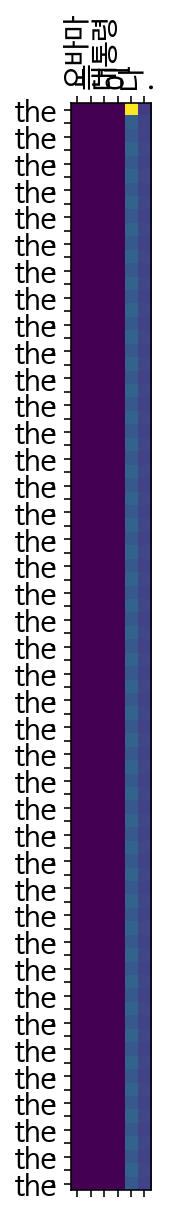

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 


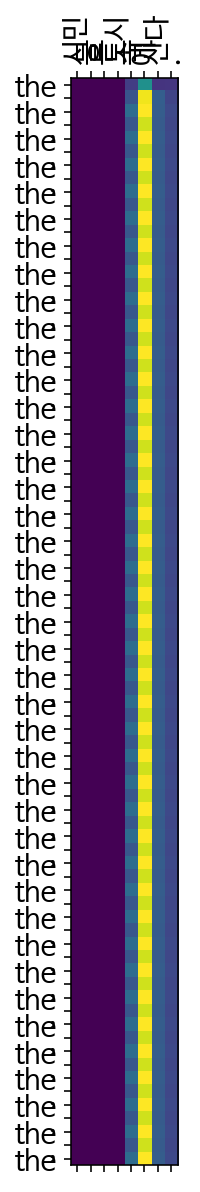

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 


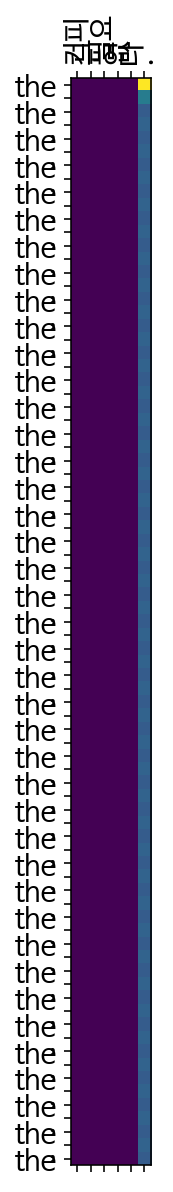

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 


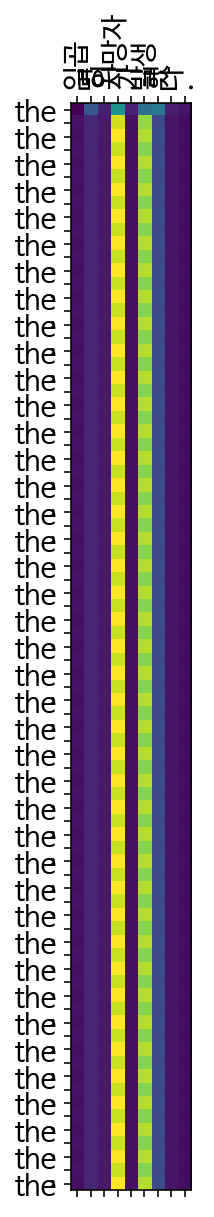

In [94]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
* 학습이 올바르게 되지 않아서 출력결과가 매우 좋지 않다.(원인을 찾기 힘들다)


### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
> 알아낸점
* Mecab 설치시 Tagger 오류 처리 
* 데이터 전처리시 데이터 타입 변경하기 Series-> List(str)


> 모호한점
* attention map 해석



### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.



>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| 번역기 모델 학습에 필요한 `텍스트 데이터 전처리`가 한국어 포함하여 잘 이루어졌다. |`구두점, 대소문자, 띄어쓰기, 한글 형태소분석` 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
>|2| `Attentional Seq2seq 모델`이 정상적으로 구동된다.| seq2seq 모델 훈련 과정에서 `training loss가 안정적`으로 떨어지면서 학습이 진행됨이 확인되었다.|
>|3|테스트 결과 `의미가 통하는 수준의 번역문`이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, `정답과 어느 정도 유사한 영어 번역`이 진행됨을 확인하였다.|



### - **자기 다짐**
* 어려운 코드 다시 한번 이해하며 읽기